In [14]:
# Install packages #
# !pip install jupyter
# !pip install numpy
# !pip install matplotlib
# !pip install torch
# !pip install xlrd
# !pip install pandas
# !pip install torchvision

In [15]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torch import Tensor
from torch.optim.optimizer import (Optimizer, required, _use_grad_for_differentiable, _default_to_fused_or_foreach,
                        _differentiable_doc, _foreach_doc, _maximize_doc)
from typing import List, Optional

In [ ]:
# Loading training data
#dataset = pd.read_csv("bmi_train.csv")
#dataset.replace({'Gender': {'Female': 0, 'Male': 1}}, inplace=True) #Gender -> boolean
#dataset = dataset.to_numpy()

# Splitting off 80% of data for training, 20% for validation
#train_split = int(0.8 * len(dataset))
#X_train = dataset[:train_split, [0,1,2]]
#y_train = dataset[:train_split, 3]
#X_test = dataset[train_split:, [0,1,2]]
#y_test = dataset[train_split:, 3]

#print(X_train)
#print(y_train)

# Loading prediction data
#prediction_dataset = pd.read_csv("bmi_validation.csv")
#prediction_dataset.replace({'Gender': {'Female': 0, 'Male': 1}}, inplace=True) #Gender -> boolean
#X_prediction = prediction_dataset.to_numpy()

# Normalize data set
#X_train_normalized = (X_train - X_train.min(0)) / (X_train.max(0) - X_train.min(0))
#X_test_normalized = (X_test - X_test.min(0)) / (X_test.max(0) - X_test.min(0))
#X_prediction_normalized = (X_prediction - X_prediction.min(0)) / (X_prediction.max(0) - X_prediction.min(0))

# Turn data to tensor
#X_train_tensor = torch.from_numpy(X_train_normalized)
#y_train_tensor = torch.from_numpy(y_train)
#X_test_tensor = torch.from_numpy(X_test_normalized)
#y_test_tensor = torch.from_numpy(y_test)
#X_prediction_tensor = torch.from_numpy(X_prediction_normalized)

In [63]:
# Loading training data
dataset = pd.read_csv("epsilon_normalized.txt", sep=' ', header=None, nrows=20000)
dataset = dataset.to_numpy()
for i in range(1, dataset.shape[1]-1):
    dataset[:, i] = [float(value.split(':')[1]) if isinstance(value, str) else value for value in dataset[:, i]]
dataset = dataset[:, :-1]
np.random.shuffle(dataset)

for i in range(1, dataset.shape[0]):
    if dataset[i - 1, 0] == -1:
        dataset[i - 1, 0] = 0


# Splitting off data for training and validation
train_split = int(0.8 * len(dataset))
X_train = dataset[:train_split, 1:].astype(np.float32)
y_train = dataset[:train_split, 0].astype(np.float32)
X_test = dataset[train_split:, 1:].astype(np.float32)
y_test = dataset[train_split:, 0].astype(np.float32)
#print(X_train)
#print(y_train)

# Normalize data set
X_train_normalized = X_train
X_test_normalized = X_test

# Turn data to tensor
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)
print(X_train_tensor.size())
print(y_train_tensor.size())
print(X_test_tensor.size())
print(y_test_tensor.size())

torch.Size([16000, 1999])
torch.Size([16000])
torch.Size([4000, 1999])
torch.Size([4000])


In [64]:
# Train and test error rate analysis function
def calculate_error_rate(X, y, w, b):
    num_samples = X.shape[0]
    y_pred = np.dot(X, w) + b
    y_pred = torch.round(torch.from_numpy(y_pred))
    error_count = torch.count_nonzero(y_pred - y)
    error_rate = error_count / num_samples
    return error_rate

Custom SGD

In [27]:
# Vanilia Gradient Descent Algorithms
def gradient_descent(X, y, learning_rate, num_iterations):
    num_samples, num_features = X.shape
    
    # Initialize weights and bias
    w = np.zeros(num_features)
    b = 0

    cost_history = []
    
    for epoch in range(num_iterations):
        # Calculate predictions
        y_pred = np.dot(X, w) + b
        
        # Calculate the difference between predictions and actual values
        error = y_pred - y
        
        # Calculate the gradient
        w_gradient = (1/num_samples) * np.dot(X.T, error)
        b_gradient = (1/num_samples) * np.sum(error)
        
        # Update theta using the learning rate and gradient
        w -= learning_rate * w_gradient
        b -= learning_rate * b_gradient
        
        # Calculate the cost (mean squared error)
        cost = np.mean(np.square(error))
        cost_history.append(cost)

        # Print the loss every 100 epochs
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(outputs[1])
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {cost.item():.8f}')
    
    return w, b, cost_history

# Train the model using gradient descent
learning_rate = 0.001
num_iterations = 1000
w, b, cost_history = gradient_descent(X_train_normalized, y_train, learning_rate, num_iterations)

# Print the learned parameters
print("Learned parameters:")

for i, w_i in enumerate(w):
    print(f"w{i} =", w_i)
print("b =", b)

# Plot the cost history
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost History")
plt.show()

# Calculate train error rate
train_error_rate = calculate_error_rate(X_train_normalized,  y_train, w, b)
print("Train error rate:", train_error_rate)
    
# Calculate test error rate if test data is provided
if X_test is not None and y_test is not None:
    test_error_rate = calculate_error_rate(X_test_normalized, y_test, w, b)
    print("Test error rate:", test_error_rate)

tensor(-0.3854, grad_fn=<SelectBackward0>)
Epoch [1/250000], Loss: 1.00000000
tensor(-0.3854, grad_fn=<SelectBackward0>)
Epoch [10/250000], Loss: 0.99998397
tensor(-0.3854, grad_fn=<SelectBackward0>)
Epoch [20/250000], Loss: 0.99996618
tensor(-0.3854, grad_fn=<SelectBackward0>)
Epoch [30/250000], Loss: 0.99994839
tensor(-0.3854, grad_fn=<SelectBackward0>)
Epoch [40/250000], Loss: 0.99993062
tensor(-0.3854, grad_fn=<SelectBackward0>)
Epoch [50/250000], Loss: 0.99991285
tensor(-0.3854, grad_fn=<SelectBackward0>)
Epoch [60/250000], Loss: 0.99989510
tensor(-0.3854, grad_fn=<SelectBackward0>)
Epoch [70/250000], Loss: 0.99987735
tensor(-0.3854, grad_fn=<SelectBackward0>)
Epoch [80/250000], Loss: 0.99985962
tensor(-0.3854, grad_fn=<SelectBackward0>)
Epoch [90/250000], Loss: 0.99984190
tensor(-0.3854, grad_fn=<SelectBackward0>)
Epoch [100/250000], Loss: 0.99982418
tensor(-0.3854, grad_fn=<SelectBackward0>)
Epoch [110/250000], Loss: 0.99980647
tensor(-0.3854, grad_fn=<SelectBackward0>)
Epoch [1

KeyboardInterrupt: 

In [19]:
# Stochastic Gradien Descent Algorithms
def stochastic_gradient_descent(X, y, learning_rate, num_epochs, batch_size):
    num_samples, num_features = X.shape
    num_batches = num_samples // batch_size

    # Initialize weights and bias
    w = np.zeros(num_features)
    b = 0
    cost_history = []

    for epoch in range(num_epochs):
        # Shuffle the data for each epoch
        permutation = np.random.permutation(num_samples)
        X_shuffled = X[permutation]
        y_shuffled = y[permutation]

        for batch in range(num_batches):
            # Select the current batch
            start = batch * batch_size
            end = (batch + 1) * batch_size
            X_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]

            # Calculate predictions
            y_pred = np.dot(X_batch, w) + b

            # Calculate the difference between predictions and actual values
            error = y_pred - y_batch

            # Calculate the gradients
            w_gradient = (1 / batch_size) * np.dot(X_batch.T, error)
            b_gradient = (1 / batch_size) * np.sum(error)

            # Update weights and bias
            w -= learning_rate * w_gradient
            b -= learning_rate * b_gradient

            # Calculate the cost (mean squared error)
            cost = np.mean(np.square(error))
            cost_history.append(cost)

        # Print the loss every 100 epochs
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(outputs[1])
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {cost.item():.8f}')
            
    return w, b, cost_history

# Train the model using stochastic gradient descent
learning_rate = 0.001
num_epochs = 1000
batch_size = 10
w, b, cost_history = stochastic_gradient_descent(X_train_normalized, y_train, learning_rate, num_epochs, batch_size)

# Print the learned parameters
print("Learned parameters:")
for i, w_i in enumerate(w):
    print(f"w{i} =", w_i)
print("b =", b)

# Plot the cost history
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost History")
plt.show()

# Calculate train error rate
train_error_rate = calculate_error_rate(X_train_normalized,  y_train, w, b)
print("Train error rate:", train_error_rate)
    
# Calculate test error rate if test data is provided
if X_test is not None and y_test is not None:
    test_error_rate = calculate_error_rate(X_test_normalized, y_test, w, b)
    print("Test error rate:", test_error_rate)

NameError: name 'outputs' is not defined

Pytorch SGD

Pytorch SGD Test (This is done by Chris for testing purpose)

Epoch [1/10000], Loss: 0.49668750, Error: 0.49668750166893005
Epoch [1000/10000], Loss: 0.19400567, Error: 0.1912499964237213
Epoch [2000/10000], Loss: 0.16407800, Error: 0.148375004529953
Epoch [3000/10000], Loss: 0.14538425, Error: 0.1301874965429306
Epoch [4000/10000], Loss: 0.13329563, Error: 0.12162499874830246
Epoch [5000/10000], Loss: 0.12525328, Error: 0.11625000089406967
Epoch [6000/10000], Loss: 0.11973827, Error: 0.11243750154972076
Epoch [7000/10000], Loss: 0.11583292, Error: 0.10925000160932541
Epoch [8000/10000], Loss: 0.11297543, Error: 0.1068124994635582
Epoch [9000/10000], Loss: 0.11081700, Error: 0.10499999672174454
Epoch [10000/10000], Loss: 0.10913745, Error: 0.10275000333786011
Trained weights: tensor([ 0.0911,  0.0423,  0.3707,  ...,  0.0096,  0.0364, -0.0435],
       requires_grad=True)
Trained bias: tensor([0.4960], requires_grad=True)


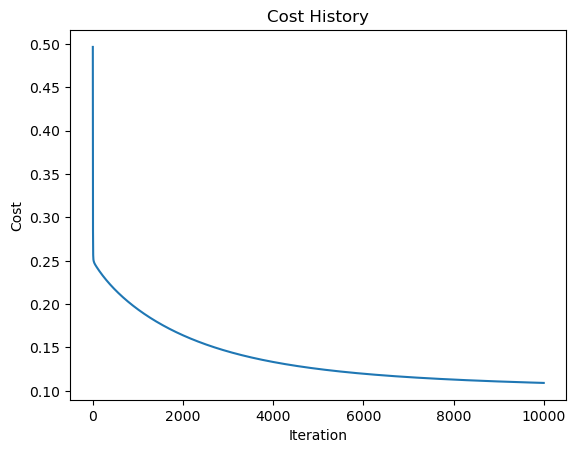

Train error rate: tensor(0.1028)
w detach tensor([ 0.0911,  0.0423,  0.3707,  ...,  0.0096,  0.0364, -0.0435])
b detach tensor([0.4960])
Test error rate: tensor(0.1268)


In [67]:
# Define the learning rate and number of epochs
learning_rate = 0.1
num_epochs = 10000

# Define the number of features
num_features = X_train_tensor.size()[1]

# Define the model parameters (weights and bias)
w = torch.zeros(num_features, dtype=torch.float, requires_grad=True)
# w = torch.tensor([1., 1., 1.], requires_grad=True)
b = torch.zeros(1, dtype=torch.float, requires_grad=True)
# b = torch.tensor([1.], requires_grad=True)
cost_history = []

# Define the loss function
criterion = torch.nn.MSELoss()

# Define the optimizer (Vanilla Gradient Descent)
optimizer = torch.optim.SGD([w, b], lr=learning_rate, weight_decay=0)

# Perform gradient descent
for epoch in range(num_epochs):
    # Forward pass
    outputs = torch.matmul(X_train_tensor.float(), w) + b
    loss = criterion(outputs, y_train_tensor.float())

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record the loss
    cost_history.append(loss.detach().numpy())
    
    # Print the loss every 1000 epochs
    if (epoch + 1) % 1000 == 0 or epoch == 0:
        train_error_rate = calculate_error_rate(X_train_normalized,  y_train, w.detach().numpy(), b.detach().numpy())
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}, Error: {train_error_rate}')
        

# Print learned parameters
print('Trained weights:', w)
print('Trained bias:', b)

# Plot the cost history
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost History")
plt.show()

# Calculate train error rate
train_error_rate = calculate_error_rate(X_train_normalized,  y_train, w.detach().numpy(), b.detach().numpy())
print("Train error rate:", train_error_rate)
print("w detach", w.detach())
print("b detach", b.detach())
    
# Calculate test error rate if test data is provided
if X_test is not None and y_test is not None:
    test_error_rate = calculate_error_rate(X_test_normalized, y_test, w.detach().numpy(), b.detach().numpy())
    print("Test error rate:", test_error_rate)

Custom SGD Class

In [69]:
class custom_optimizer_SGD(Optimizer):
    def __init__(self, params, lr=required, weight_decay=0 ):
        if lr is not required and lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if weight_decay < 0.0:
            raise ValueError(f"Invalid weight_decay value: {weight_decay}")
        defaults = dict(lr=lr, weight_decay=weight_decay)
        super().__init__(params, defaults)
                
    def step(self):
        for group in self.param_groups:
            for param in group['params']:
                if param.grad is None:
                    continue
                grad = param.grad.data
                weight_decay = group['weight_decay']
                lr = group['lr']
                param.data.add_(-lr, grad)
                if weight_decay != 0:
                    param.data.add_(-lr * weight_decay, param.data)

Neural Network

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (activation_stack): Sequential(
    (0): Linear(in_features=1999, out_features=1, bias=True)
  )
)
tensor(0.0149, grad_fn=<SelectBackward0>)
Epoch [1/5000], Loss: 0.47869319
tensor(0.1064, grad_fn=<SelectBackward0>)
Epoch [100/5000], Loss: 0.39726353
tensor(0.1803, grad_fn=<SelectBackward0>)
Epoch [200/5000], Loss: 0.34485587
tensor(0.2394, grad_fn=<SelectBackward0>)
Epoch [300/5000], Loss: 0.31149045
tensor(0.2866, grad_fn=<SelectBackward0>)
Epoch [400/5000], Loss: 0.29019707
tensor(0.3244, grad_fn=<SelectBackward0>)
Epoch [500/5000], Loss: 0.27656010
tensor(0.3546, grad_fn=<SelectBackward0>)
Epoch [600/5000], Loss: 0.26778191
tensor(0.3789, grad_fn=<SelectBackward0>)
Epoch [700/5000], Loss: 0.26208997
tensor(0.3984, grad_fn=<SelectBackward0>)
Epoch [800/5000], Loss: 0.25836068
tensor(0.4140, grad_fn=<SelectBackward0>)
Epoch [900/5000], Loss: 0.25588199
tensor(0.4267, grad_fn=<SelectBackward0>)
Epoch [1000/5000], Loss: 0.2

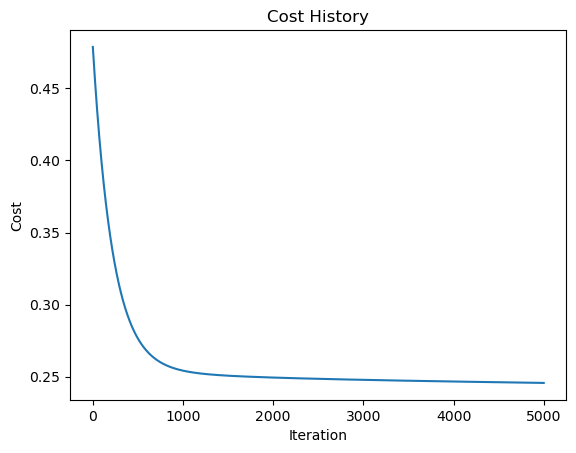

In [72]:
# Define the number of features
num_features = X_train_tensor.size()[1]

# Define a custom neural network class

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.activation_stack = nn.Sequential(
            nn.Linear(num_features, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.activation_stack(x)
        return torch.squeeze(logits)
    
# Define the learning rate and number of epochs
learning_rate = 0.001
num_epochs = 5000

# Define the model parameters
cost_history = []

# Define neural network model, loss criterion and optimizer
criterion = torch.nn.MSELoss()
NeuralNetwork_model = NeuralNetwork()
print(NeuralNetwork_model)
optimizer = custom_optimizer_SGD(NeuralNetwork_model.parameters(), lr=learning_rate, weight_decay = 0)

#for name, param in NeuralNetwork_model.named_parameters():
#    print( name )
#    values = torch.ones( param.shape )
#    param.data = values
    
# Perform training
NeuralNetwork_model.train()
for epoch in range(num_epochs):
    # Forward propagation to obtain the predicted output
    outputs = NeuralNetwork_model(X_train_tensor.float())
    
    # Calculate the loss
    loss = criterion(outputs, y_train_tensor.float())
    
    # Backward propagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Record the loss
    cost_history.append(loss.item())
    
    # Print the loss every 100 epochs
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(outputs[1])
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')
        
# Print learned parameters
for name, param in NeuralNetwork_model.named_parameters():
    if param.requires_grad:
        print(f'{name}: {param.data}')
        
        
# Plot the cost history
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost History")
plt.show()

# Calculate train error rate
# train_error_rate = calculate_error_rate(X_train_normalized,  y_train, w.T.detach().numpy(), b.detach().numpy())
# print("Train error rate:", train_error_rate)
    
# Calculate test error rate if test data is provided
# if X_test is not None and y_test is not None:
#    test_error_rate = calculate_error_rate(X_test_normalized, y_test, w.T.detach().numpy(), b.detach().numpy())
#    print("Test error rate:", test_error_rate)

Fedearted Learning Algorithm

In [ ]:
# Dataset preprocessing for Federated Learning
def split_data_for_client():
    dataset

In [ ]:
# Define a custom class for each client so they can update separately
class ClientUpdate:
    def __init__(self, model, criterion, optimizer, train_data):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_data = train_data

    def update_weights(self, num_epochs):
        self.model.train()
        for epoch in range(num_epochs):
            for inputs, targets in self.train_data:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()

        return self.model.state_dict()

def send_client_weights(server, weights):
    server.append(weights)
    
def aggregate_weights_on_server(client_weights_list):
    aggregated_weights = {}
    # Aggregate the client weights
    for key in client_weights_list[0].keys():
        aggregated_weights[key] = torch.stack([weights[key] for weights in client_weights_list]).mean(dim=0)

# Define the learning rate and number of epochs
learning_rate = 0.01
num_epochs = 5000
batch_size = 1
num_clients = 5

# Define the model parameters
cost_history = []

# Define neural network model, loss criterion and optimizer
model = NeuralNetwork()
criterion = torch.nn.MSELoss()
optimizer = custom_optimizer_SGD(model.parameters(), lr=learning_rate)

# Add the client data to the train_data list
data

# Perform training
num_clients = len(train_data)
global_weights = model.state_dict()

for epoch in range(num_epochs):
    m = max(num_clients, 1)
    selected_clients = torch.randperm(num_clients)[:m]
    loss = 0.00

    for client in selected_clients:
        client_data = train_data[client]
        client_update = ClientUpdate(model, criterion, optimizer, client_data[client])
        client_weights = client_update.update_weights(num_epochs)

        # Send client weights to the server
        send_client_weights(global_weights, client_weights)

    # Aggregate client weights on the server
    aggregated_weights = aggregate_weights_on_server(global_weights)

    # Update global weights with aggregated weights
    model.load_state_dict(aggregated_weights)

    # Record the loss
    cost_history.append(loss.item())

    # Print the loss every 100 epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(outputs[1])
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')

KeyError: 0